In [193]:
import warnings

import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import skewtest
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score


warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)

In [194]:
"""
TEAM MEMBER’S DETAILS
Group Name: Banking Insights Squad
Group: Members: Canmert Demir & Joseph Pang 
Names: Canmert Demir-Bank Marketing (Campaign) -- Group Project
Email: canmertdemir2@gmail.com
Country: Turkey
College/Company: Msc Bartin University-Applied Mathematics / Data Glacier
Specialization: Data Science

Name: Joseph Pang-Bank Marketing (Campaign) -- Group Project
Email: joseph302156@gmail.com
Country: United States
College/Company: University of California, Berkeley/ Data Glacier
Specialization: Data Science
Github Repository: https://github.com/Canmertdemir/Canmertdemir-DataGlacierWeek10
"""


'\nTEAM MEMBER’S DETAILS\nGroup Name: Banking Insights Squad\nGroup: Members: Canmert Demir & Joseph Pang \nNames: Canmert Demir-Bank Marketing (Campaign) -- Group Project\nEmail: canmertdemir2@gmail.com\nCountry: Turkey\nCollege/Company: Msc Bartin University-Applied Mathematics / Data Glacier\nSpecialization: Data Science\n\nName: Joseph Pang-Bank Marketing (Campaign) -- Group Project\nEmail: joseph302156@gmail.com\nCountry: United States\nCollege/Company: University of California, Berkeley/ Data Glacier\nSpecialization: Data Science\nGithub Repository: https://github.com/Canmertdemir/Canmertdemir-DataGlacierWeek10\n'

In [195]:
#There are four datasets:
#1) bank-additional-full.csv with all examples (41188) and 20 inputs,
# ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
#2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.

df_test = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank-additional.csv", sep=';') #testdata
df = pd.read_csv("C:\\Users\\Can\\PycharmProjects\\pythonProject\\DataGlacierWeek9\\bank-additional-full.csv", sep=';') #traindata

df_test = df_test.sort_index(axis=1).sort_index(axis=0)
df = df.sort_index(axis=1).sort_index(axis=0)

#It is hard to convert duration into bussiness metrics, so we decided to drop it.
df.drop("duration", axis=1, inplace=True) #Dropping useless variable

In [196]:
#Some of properties of updated dataset bank_additional
def quick_look(dataframe, head=5):

    print("###################### SHAPE ##########################")
    print(dataframe.shape)

    print("########################## Describe #######################")
    print(dataframe.describe().T)

    print("####################### Variable Types ##################")
    print(dataframe.dtypes)

    print("###################### Head ##########################")
    print(dataframe.head(head))

    print("###################### Tail ##########################")
    print(dataframe.tail(head))
    print("###################### NA ##########################")
    print(dataframe.isna())
    print("###################### NUMBER OF NA ##########################")
    print(dataframe.isna().sum())

quick_look(df)

###################### SHAPE ##########################
(41188, 20)
########################## Describe #######################
                   count     mean     std      min      25%      50%      75%      max
age            41188.000   40.024  10.421   17.000   32.000   38.000   47.000   98.000
campaign       41188.000    2.568   2.770    1.000    1.000    2.000    3.000   56.000
cons.conf.idx  41188.000  -40.503   4.628  -50.800  -42.700  -41.800  -36.400  -26.900
cons.price.idx 41188.000   93.576   0.579   92.201   93.075   93.749   93.994   94.767
emp.var.rate   41188.000    0.082   1.571   -3.400   -1.800    1.100    1.400    1.400
euribor3m      41188.000    3.621   1.734    0.634    1.344    4.857    4.961    5.045
nr.employed    41188.000 5167.036  72.252 4963.600 5099.100 5191.000 5228.100 5228.100
pdays          41188.000  962.475 186.911    0.000  999.000  999.000  999.000  999.000
previous       41188.000    0.173   0.495    0.000    0.000    0.000    0.000    7.000
##

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   campaign        41188 non-null  int64  
 2   cons.conf.idx   41188 non-null  float64
 3   cons.price.idx  41188 non-null  float64
 4   contact         41188 non-null  object 
 5   day_of_week     41188 non-null  object 
 6   default         41188 non-null  object 
 7   education       41188 non-null  object 
 8   emp.var.rate    41188 non-null  float64
 9   euribor3m       41188 non-null  float64
 10  housing         41188 non-null  object 
 11  job             41188 non-null  object 
 12  loan            41188 non-null  object 
 13  marital         41188 non-null  object 
 14  month           41188 non-null  object 
 15  nr.employed     41188 non-null  float64
 16  pdays           41188 non-null  int64  
 17  poutcome        41188 non-null 

In [198]:
#Categorical Variable Analysis
#The distribution of categorical variables isn't balanced across classes.
#The target variable 'y' exhibits an imbalance.
#'Education' predominantly comprises individuals with university and high school degrees.
#'Housing' classes are distributed closely, with 'yes' being the more dominant class.
#'Job' shows three dominant classes: admin, blue-collar, and technician. Other job categories exhibit minimal differences.
#'Loan' has three classes, with 'no' being the dominant one among all others.
#'Marital' features three classes, with the majority being married or single. 'Married' stands as the dominant class.
#'Month' encompasses 10 classes. May, June, July, August, and November hold significant importance.
#'Poutcome' showcases three classes, with the 'nonexistent' class being the dominant one. This suggests that the majority of people have not attended a campaign before.

def grab_col_names(dataframe):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    print("Categorical Variables", cat_cols)

    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes in [int, float]]
    print("Those variables numerical  variables", numerical_cols)

    numerical_but_categorical_variable = [col for col in dataframe.columns if
                                          dataframe[col].nunique() < 10 and dataframe[col].dtypes in [int, float]]
    print("Those variables numerical but categorical variables", numerical_but_categorical_variable)

    categorical_but_cardianal_variable = [col for col in dataframe.columns if
                                          dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) not in [int,
                                                                                                               float]]
    print("Those variables categorical variables but cardinal variables", categorical_but_cardianal_variable)

    cat_cols = cat_cols + numerical_but_categorical_variable
    cat_cols = [col for col in cat_cols if col not in categorical_but_cardianal_variable]
    print("All categorical variables are:", cat_cols)

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Eğer aynı sütun hem numerical_but_categorical_variable hem de categorical_but_cardianal_variable içindeyse, birini çıkaralım.
    for col in num_cols:
        if col in numerical_but_categorical_variable and col in categorical_but_cardianal_variable:
            categorical_but_cardianal_variable.remove(col)

    print("All numerical variables are:", num_cols)

    print(f"Number Of Observation: {dataframe.shape[0]}")
    print(f"Number Of Variable: {dataframe.shape[1]}")
    print(f"Number Of Categorical Variable: {len(cat_cols)}")
    print(f"Number Of Numerical Variable: {len(num_cols)}")
    print(f"Number Of Categorical but Cardinal Variables: {len(categorical_but_cardianal_variable)}")
    print(f"Number Of Numerical but Cardinal Variables: {len(numerical_but_categorical_variable)}")

    return cat_cols, num_cols, categorical_but_cardianal_variable

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)

Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Those variables numerical but categorical variables []
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'pdays']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Number Of Observation: 41188
Number Of Variable: 20
Number Of Categorical Variable: 11
Number Of Numerical Variable: 5
Number Of Categorical but Cardinal Variables: 6
Number Of Numerical but Cardinal Variables: 0


In [199]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * IQR
    low_limit = quartile1 - 1.5 * IQR
    return low_limit, up_limit
def check_outlier(dataframe, col_name):

    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

cat_cols, num_cols, categorical_but_cardianal_variable = grab_col_names(df)

for col in num_cols:
    print(f"{col}: {check_outlier(df, col)}")

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


for col in num_cols:
    print(col, grab_outliers(df, col))
    

Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Those variables numerical but categorical variables []
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'pdays']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Number Of Observation: 41188
Number Of Variable: 20
Number Of Categorical Variable: 11
Number Of Numerical Variable: 5
Number Of Categorical but Cardinal Variables: 6
Number Of Numerical but Cardinal Variables: 0
cons.conf.idx: False
cons.price.idx: False
emp.var.rate: False
euribor3m: False
nr.empl

In [200]:
def missing_values_table(dataframe, na_name=False):

    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


na_cols = missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


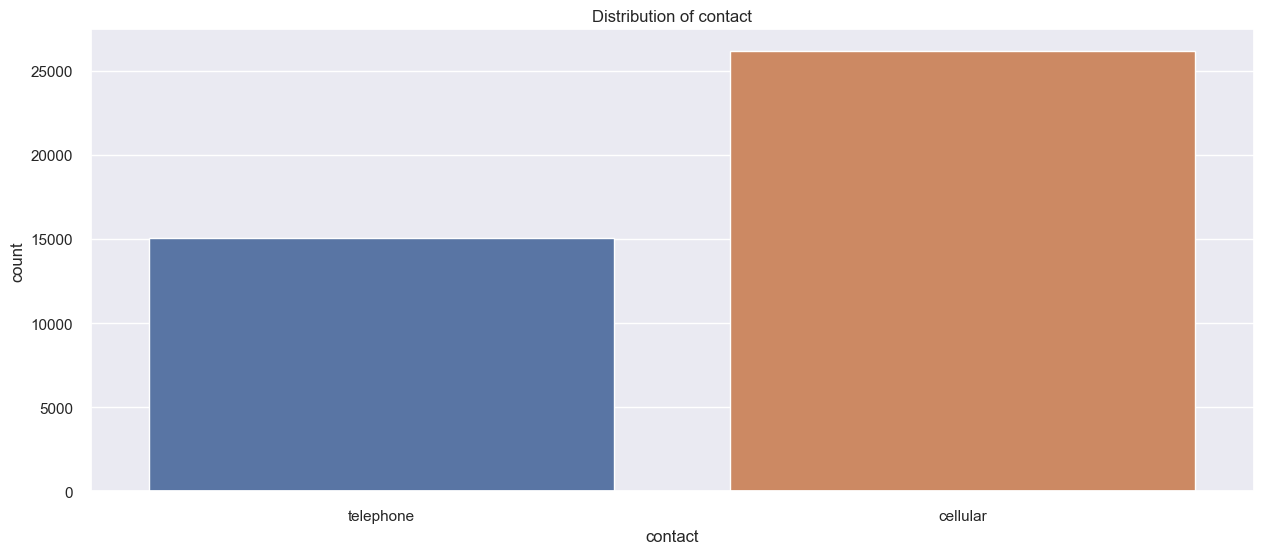

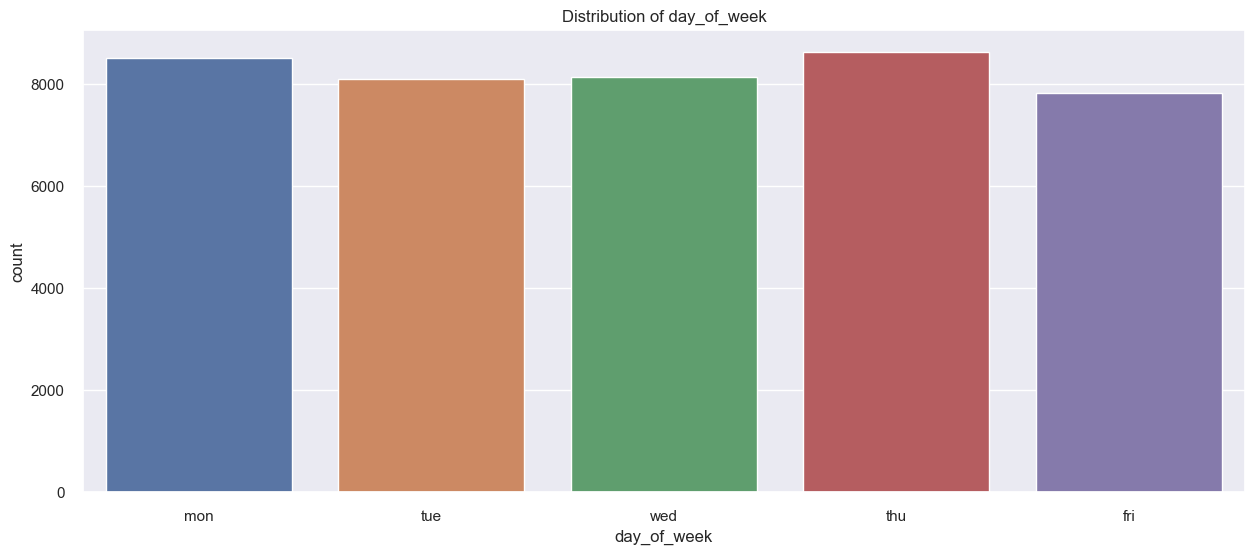

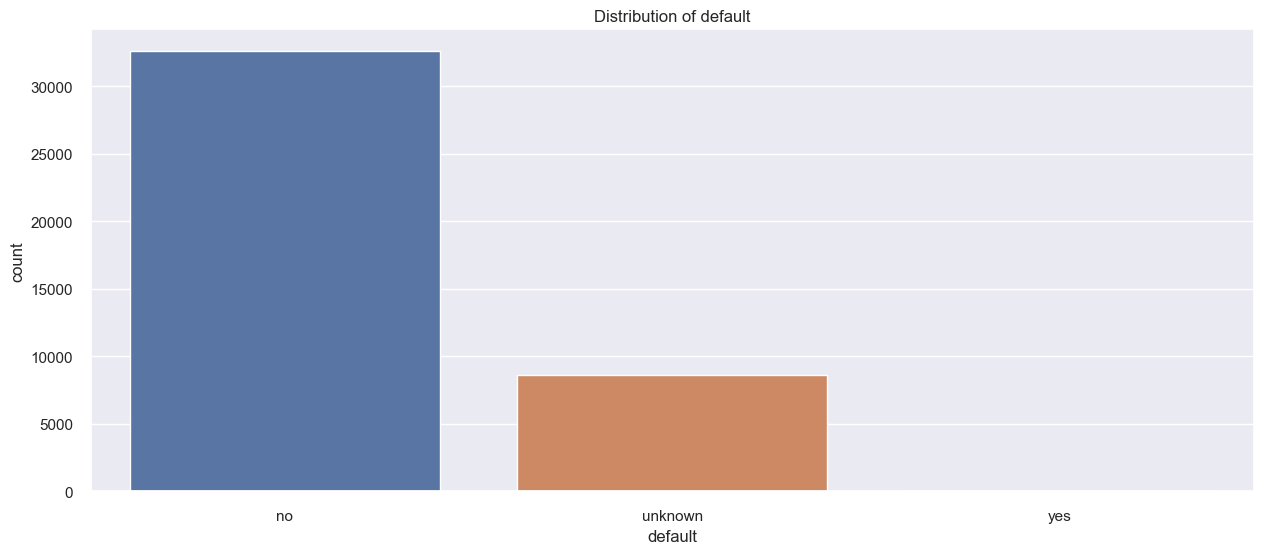

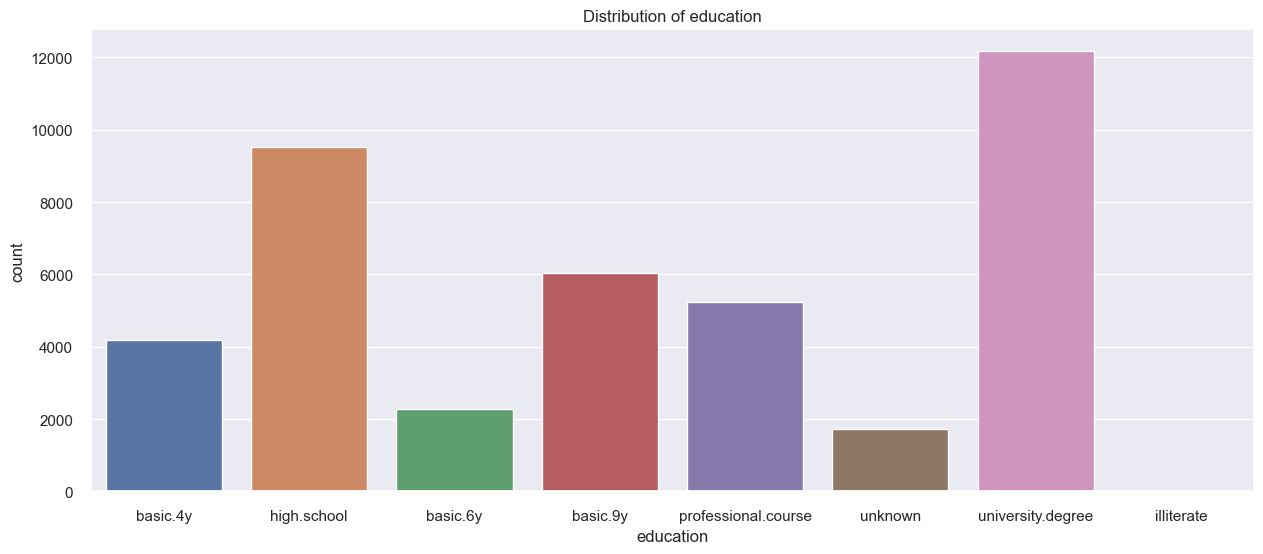

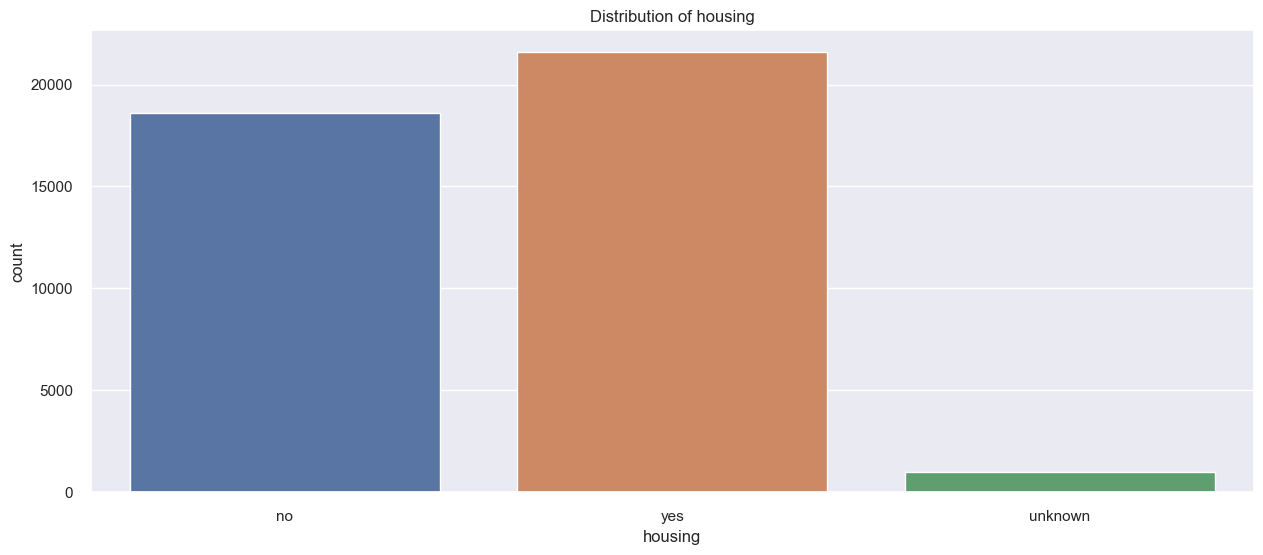

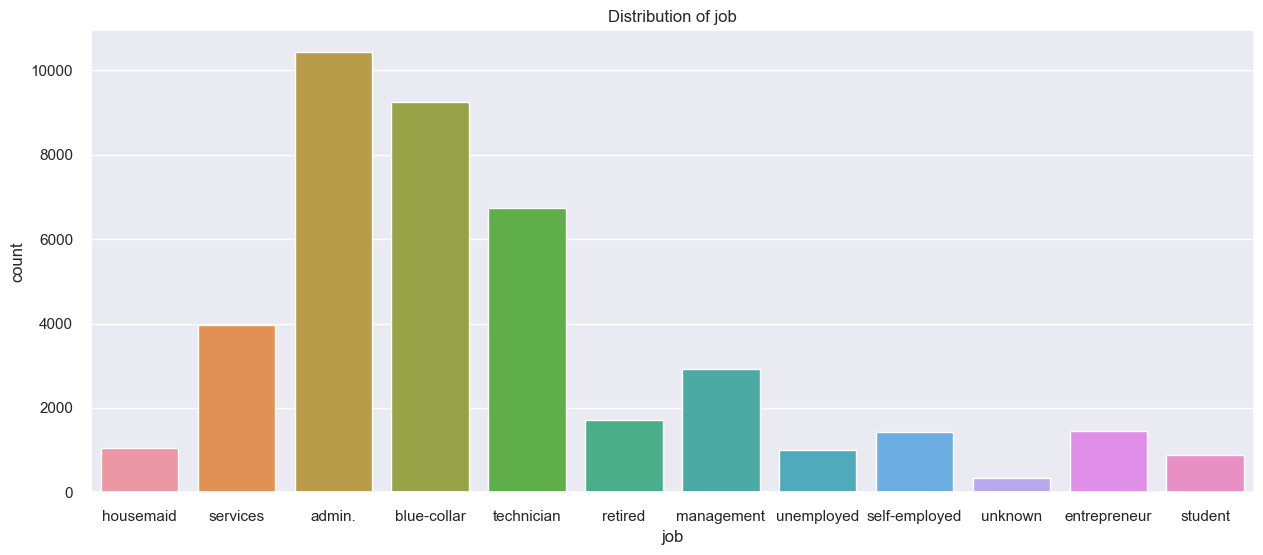

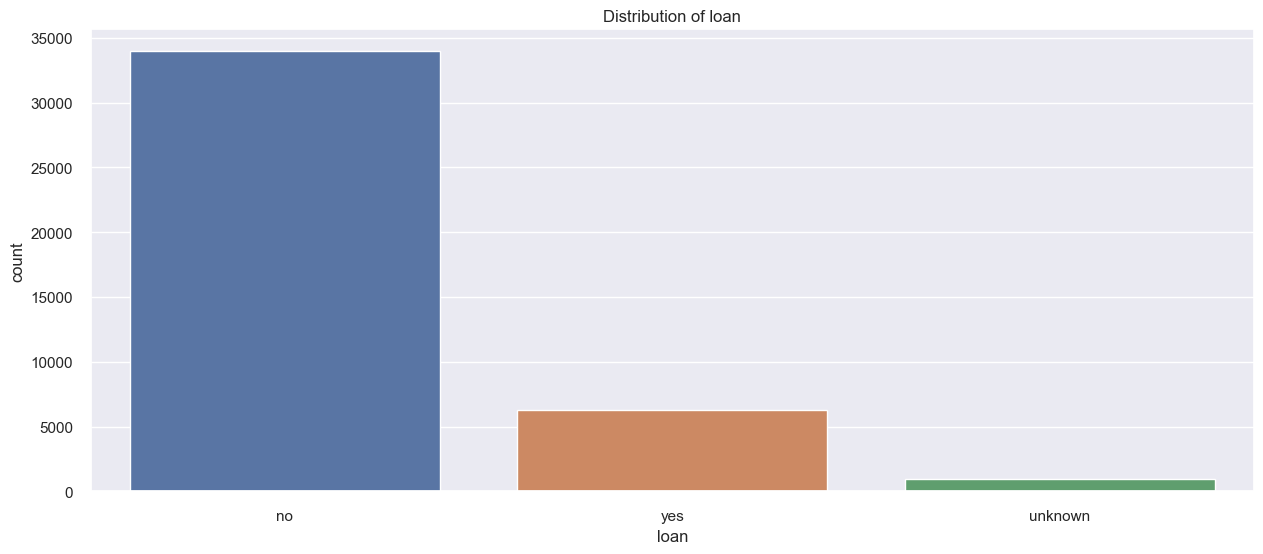

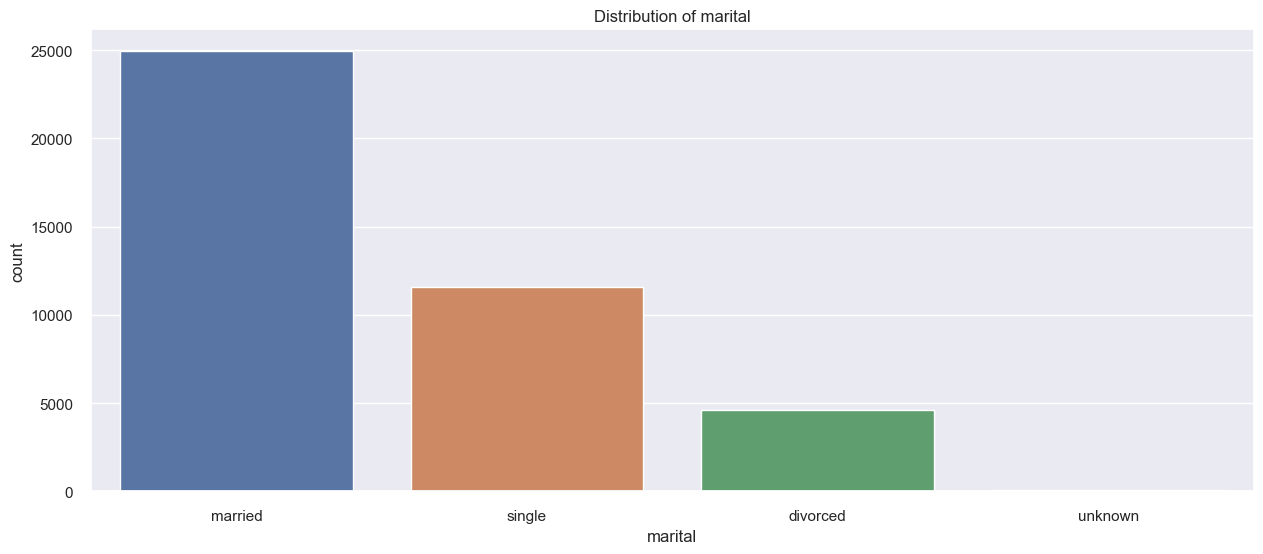

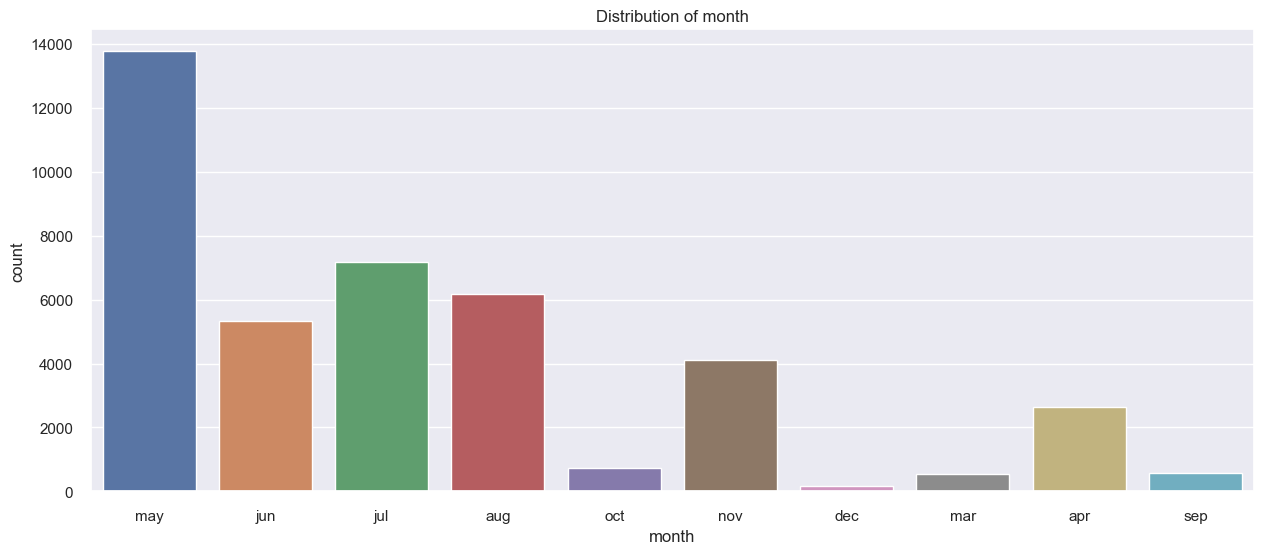

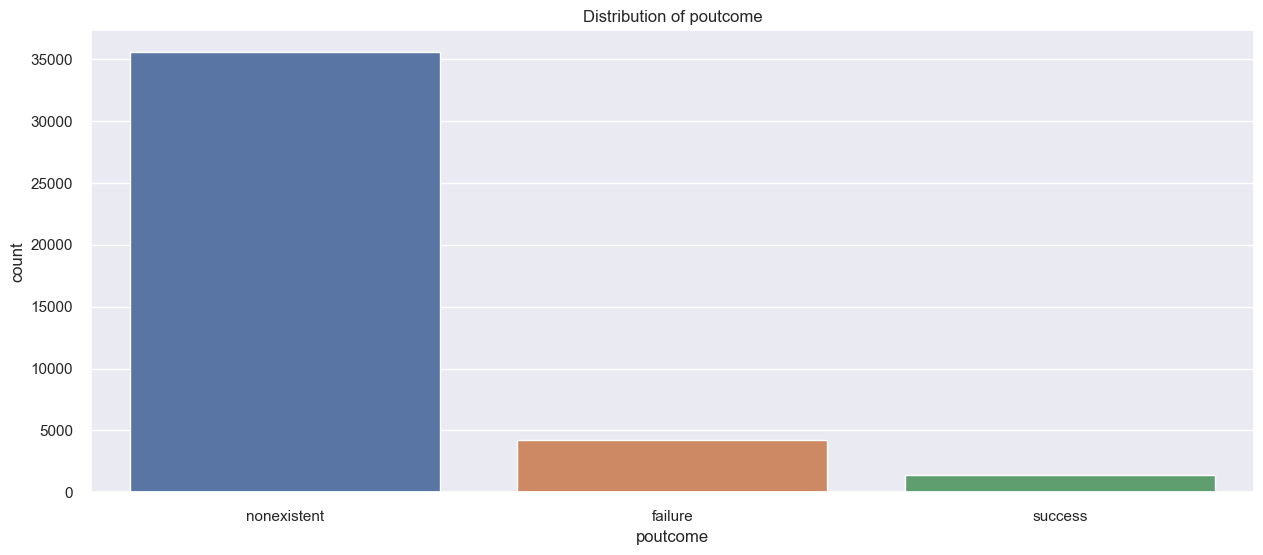

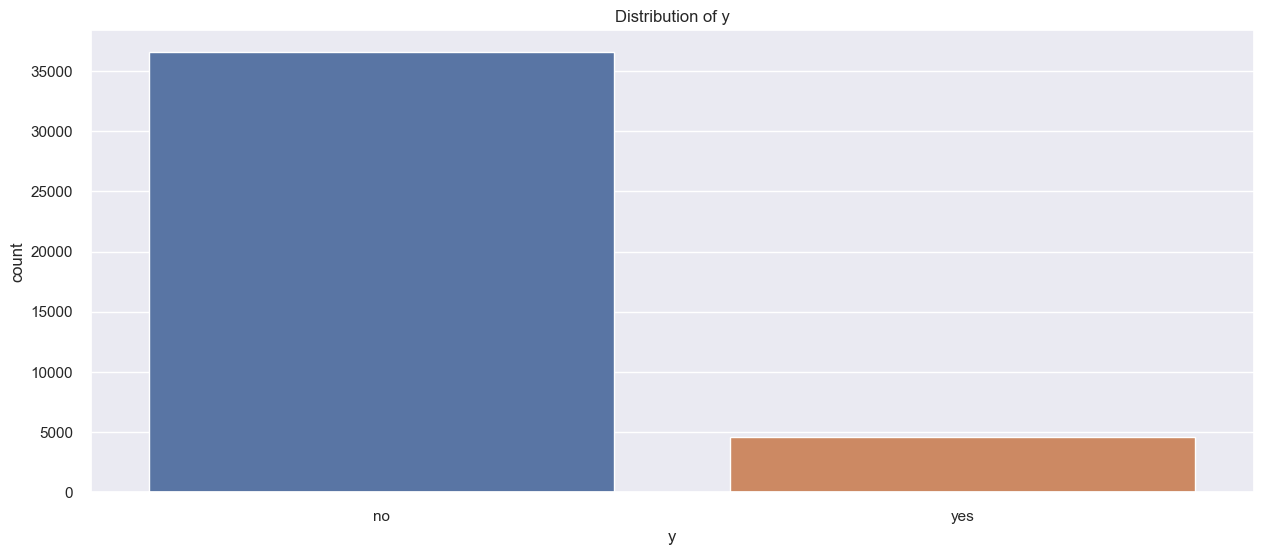

In [201]:

def categoric_count_plt(dataframe, plot=False):

    for col in dataframe[cat_cols].columns:

        if plot:
            plt.figure(figsize=(15, 6))
            sns.countplot(x=col, data=df[cat_cols])
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.show()


categoric_count_plt(df, plot=True)

Categorical Variables ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
Those variables numerical  variables ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Those variables numerical but categorical variables []
Those variables categorical variables but cardinal variables ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'pdays']
All categorical variables are: ['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome', 'y']
All numerical variables are: ['cons.conf.idx', 'cons.price.idx', 'emp.var.rate', 'euribor3m', 'nr.employed']
Number Of Observation: 41188
Number Of Variable: 20
Number Of Categorical Variable: 11
Number Of Numerical Variable: 5
Number Of Categorical but Cardinal Variables: 6
Number Of Numerical but Cardinal Variables: 0
Outliers Check


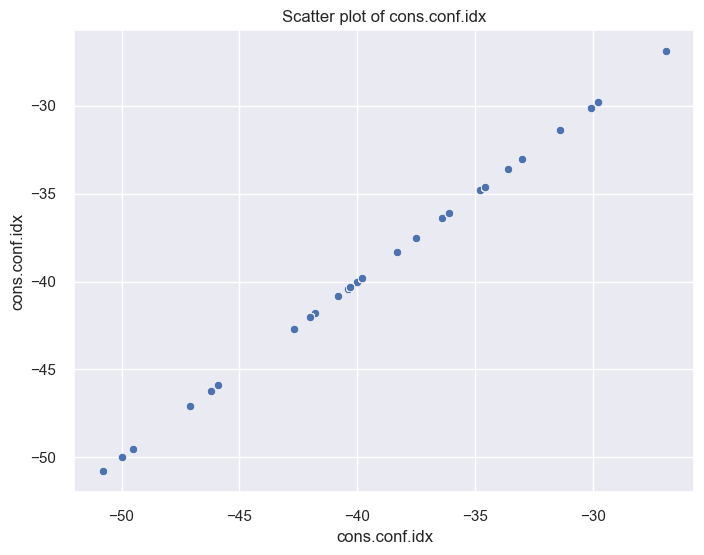

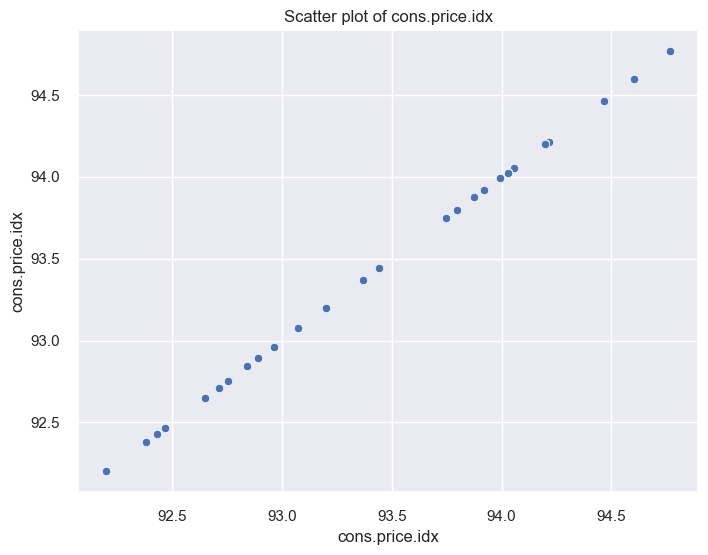

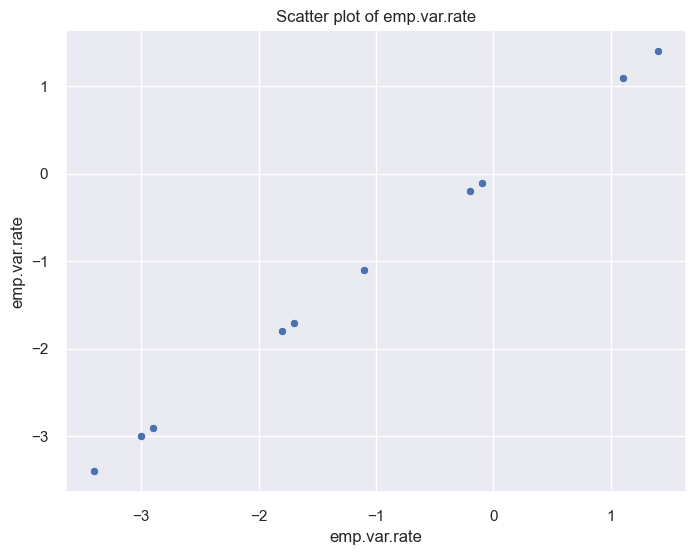

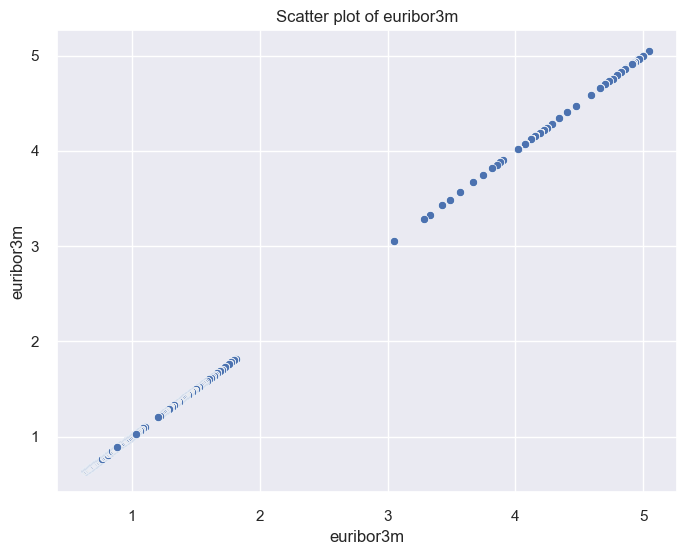

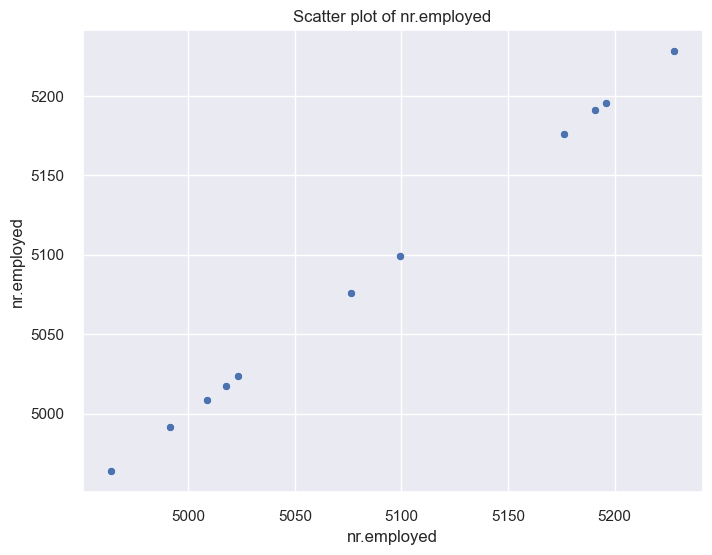

In [202]:
# Scatter Plot of Numerical Variables to see outliars.
# Perfect positive correlation exist.
def num_scatter(dataframe, numerical_cols, plot=False):
    print("Outliers Check")

    if plot:
        for col in numerical_cols:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=dataframe, x=col, y=col, palette="viridis")
            plt.xlabel(col)
            plt.ylabel(col)
            plt.title(f"Scatter plot of {col}")
            plt.show(block=True)


cat_cols, num_cols, categorical_but_cardinal_variable = grab_col_names(df)
num_scatter(df, num_cols, plot=True)

In [203]:
def analyze_skewness_distribution(data):

    skewness_distribution_results = {}

    for column in data.columns:
        if data[column].dtype == int or data[column].dtype == float:
            _, skewness_pvalue = skewtest(data[column].astype(float).values)

            if skewness_pvalue < 0.05:
                skewness = data[column].skew()
                if skewness < 0:
                    distribution = 'Left Skew'
                elif skewness > 0:
                    distribution = 'Right Skew'
                else:
                    distribution = 'Normal'
            else:
                distribution = 'Normal'

            skewness_distribution_results[column] = distribution

            print(f"{column}: {distribution}")

    return skewness_distribution_results

skewness_distribution_results = analyze_skewness_distribution(df)
# Numerical variables do not distribute normally.

cons.conf.idx: Right Skew
cons.price.idx: Left Skew
emp.var.rate: Left Skew
euribor3m: Left Skew
nr.employed: Left Skew


Numerical variables distribution Check
                   count     mean    std      min       5%      10%      20%      30%      40%      50%      60%      70%      80%      90%      95%      max
cons.conf.idx  41188.000  -40.503  4.628  -50.800  -47.100  -46.200  -46.200  -42.700  -42.000  -41.800  -40.000  -36.400  -36.400  -36.100  -33.600  -26.900
cons.price.idx 41188.000   93.576  0.579   92.201   92.713   92.893   92.893   93.200   93.444   93.749   93.918   93.994   93.994   94.465   94.465   94.767
emp.var.rate   41188.000    0.082  1.571   -3.400   -2.900   -1.800   -1.800   -1.700   -0.100    1.100    1.100    1.400    1.400    1.400    1.400    1.400
euribor3m      41188.000    3.621  1.734    0.634    0.797    1.046    1.299    1.410    4.191    4.857    4.864    4.960    4.962    4.964    4.966    5.045
nr.employed    41188.000 5167.036 72.252 4963.600 5017.500 5076.200 5099.100 5099.100 5191.000 5191.000 5195.800 5228.100 5228.100 5228.100 5228.100 5228.100


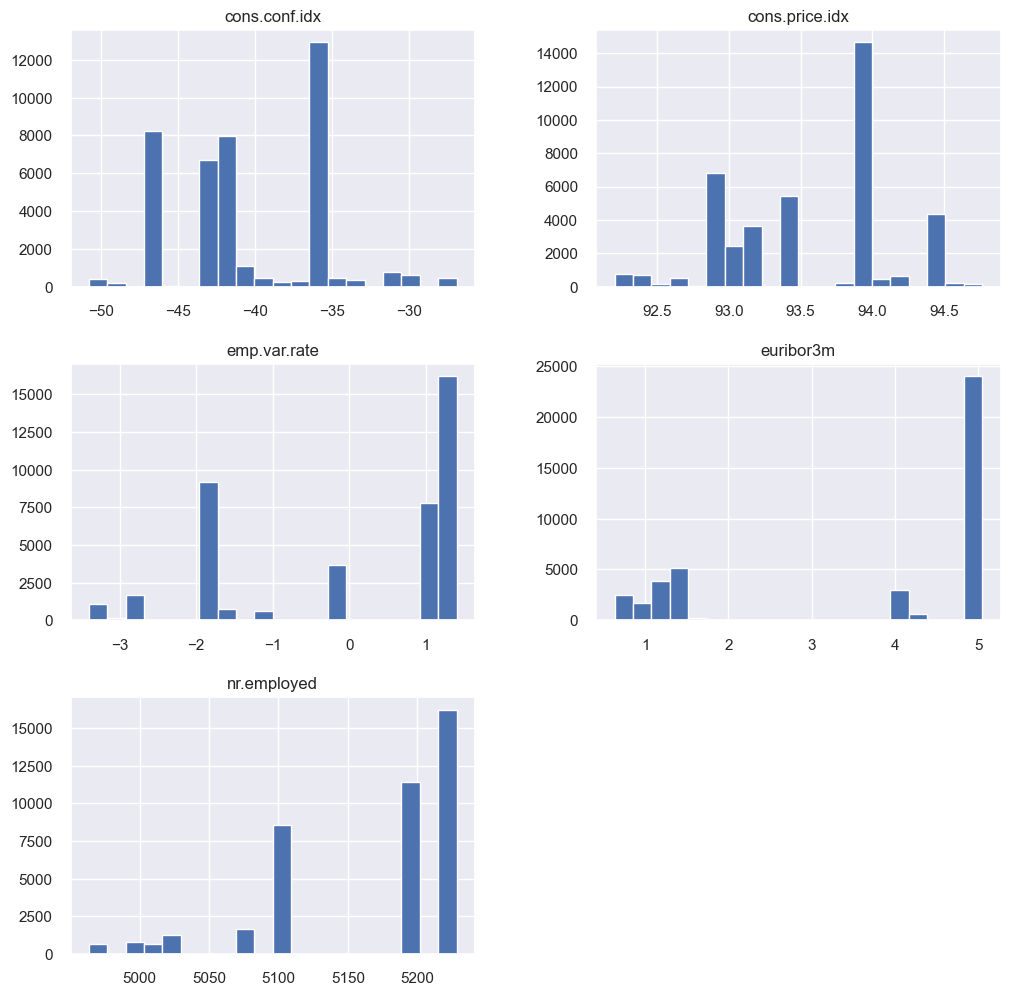

In [204]:
def num_summary(dataframe, numerical_col, plot=False):

    print("Numerical variables distribution Check")
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

num_summary(df, num_cols, plot=True)

In [205]:
age_vs_campaign = df.groupby(["age", "campaign"]).size().reset_index(name='count')
age_vs_campaign_target = age_vs_campaign.groupby("age")['count'].max()
max_campaign_age = age_vs_campaign_target[age_vs_campaign_target == age_vs_campaign_target.max()]
print(max_campaign_age)


default_count_by_group = df.groupby(["age", "campaign", "contact", "day_of_week"])['default'].value_counts().reset_index(name='default_count')
print(default_count_by_group)

default_yes = default_count_by_group[default_count_by_group['default'] == 'yes']
default_no = default_count_by_group[default_count_by_group['default'] == 'no']
default_unknown = default_count_by_group[default_count_by_group['default'] == 'unknown']

print(default_yes) #Default yes people value counts shows that tuesday is good day to call. Old campain stragegy is bad.
# Also default
print(default_no)# Default no people cardinality is 3976 so bank must be worked on those people.
# Changing strategy, give some promotions such as discount.

print(default_unknown) # Default unknown people cardinality is 2336. Bank should learn they take campaign or not.
# Or if we assume they all do not take campaign before, bank would change campaign stragey for those people.



housing_loan_vs_default_no = df[(df['housing'] == 'yes') & (df['loan'] == 'yes') & (df['default'] == 'no')]
print(housing_loan_vs_default_no)

housing_loan_vs_default_no_y_yes = housing_loan_vs_default_no[housing_loan_vs_default_no['y'] =='yes']
print(housing_loan_vs_default_no_y_yes) # 373 people in this group

housing_loan_vs_default_no_y_no = housing_loan_vs_default_no[housing_loan_vs_default_no['y'] =='no']
print(housing_loan_vs_default_no_y_no) #2595 people in this group, so banking strategy group must work on this people.
# For example, they can try same strategy which used on housing_loan_vs_default_no_y_yes people.

housing_loan_vs_default_yes= df[(df['housing'] == 'yes') & (df['loan'] == 'yes') & (df['default'] == 'yes')]
print(housing_loan_vs_default_yes) # Empty set, these people churned, so strategy is those people must integrate the
# system by using promotion, discount.

housing_loan_vs_default_yes_y_no = housing_loan_vs_default_yes[housing_loan_vs_default_yes['y'] =='yes']
print(housing_loan_vs_default_yes_y_no)  #Banking campaing strategist must focus housing=yes, loan=yes people


age
31    821
Name: count, dtype: int64
      age  campaign   contact day_of_week  default  default_count
0      17         1  cellular         tue       no              1
1      17         2  cellular         fri       no              2
2      17         3  cellular         fri       no              1
3      17         3  cellular         wed       no              1
4      18         1  cellular         fri       no              3
...   ...       ...       ...         ...      ...            ...
6309   92         3  cellular         wed  unknown              1
6310   94         1  cellular         wed       no              1
6311   95         1  cellular         thu       no              1
6312   98         1  cellular         fri  unknown              1
6313   98         2  cellular         fri  unknown              1

[6314 rows x 6 columns]
      age  campaign   contact day_of_week default  default_count
1188   31         2  cellular         tue     yes              1
4040   48    

In [206]:
def cor_analiz_cardinals(dataframe, plot=True):

    numeric_data = dataframe.select_dtypes(include=['float64', 'int64'])
    corr = numeric_data.corr()

    if plot:

        sns.set(rc={"figure.figsize": (12, 12)})
        sns.heatmap(corr, cmap="coolwarm", annot=True)
        plt.show()

        correlated_pairs = {}
        for i in range(len(corr.columns)):
            for j in range(i + 1, len(corr.columns)):
                if abs(corr.iloc[i, j]) > 0.6:  # Checking absolute correlation value
                    pair = corr.columns[i], corr.columns[j]
                    correlated_pairs[pair] = corr.iloc[i, j]

        return correlated_pairs


correlated_variables = cor_analiz_cardinals(df, plot=False)
print(correlated_variables)

# {('cons.price.idx', 'emp.var.rate'): 0.7753341708348437, ('cons.price.idx', 'euribor3m'): 0.6882301070374915, ('emp.var.rate', 'euribor3m'): 0.9722446711516167,
# ('emp.var.rate', 'nr.employed'): 0.9069701012560616, ('euribor3m', 'nr.employed'): 0.9451544313982757}

# 'emp.var.rate' and  euribor3m variables have high correlation between numerical variables.

#Last week,we merged two datasets which calls bank_additional_full and bank_full. There was a 4 different variable between dataset.
# we used to fill null values mode and median, but it affect ML model performance.
# Filling with null values with NaN to get more efficient prediction.
# Now, further process, we will use bank_additional_full.csv which does not contains any null variable.
# Old feature engineering results show that there was not any good feature which support model's prediction ability.
# In this case, we repeat feature engineering part.
# First, we create basic model to see which feature affect model performance.
#We observed that nr.employed(most important feature), cons.conf.idx, month, contact, poutcome, cons.price.idx, pdays


None


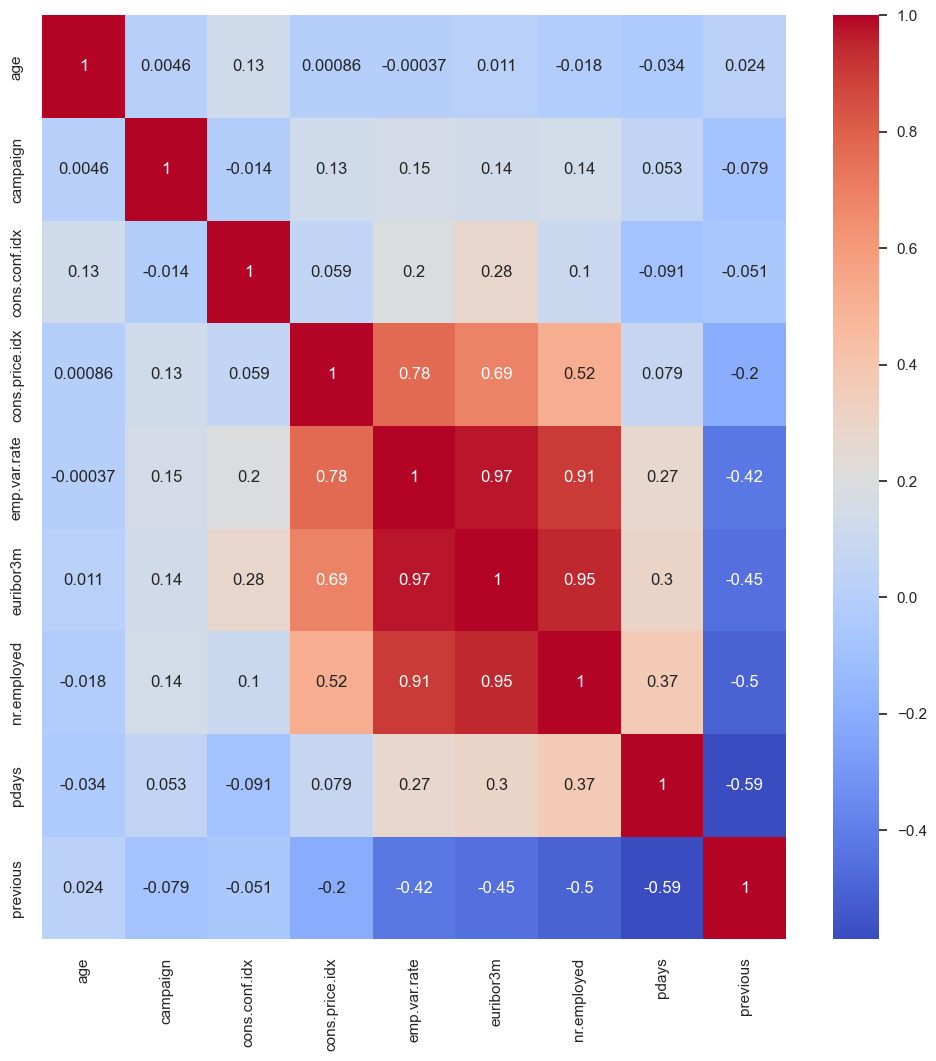

{('cons.price.idx', 'emp.var.rate'): 0.7753341708348437, ('cons.price.idx', 'euribor3m'): 0.6882301070374915, ('emp.var.rate', 'euribor3m'): 0.9722446711516167, ('emp.var.rate', 'nr.employed'): 0.9069701012560616, ('euribor3m', 'nr.employed'): 0.9451544313982757}


In [207]:
# Now, we clean data and protect overfitting.
correlated_variables_updated = cor_analiz_cardinals(df)
print(correlated_variables_updated)


In [208]:
# Define the weights
weight_euribor = 0.4
weight_price = 0.3
weight_conf = 0.3

# Calculate the index
df['economic_index'] = (weight_euribor * df['euribor3m']) + (weight_price * df['cons.price.idx']) + (weight_conf * df['cons.conf.idx'])
df_test['economic_index'] = (weight_euribor * df_test['euribor3m']) + (weight_price * df_test['cons.price.idx']) + (weight_conf * df_test['cons.conf.idx'])

df['emp_var_euribor3m_sum'] = df['emp.var.rate'] + df['euribor3m']
df_test['emp_var_euribor3m_sum'] = df_test['emp.var.rate'] + df_test['euribor3m']

df['emp.var.rate_euribor3m_mult'] = df['emp.var.rate'] * df['euribor3m']
df_test['emp.var.rate_euribor3m_mult'] = df_test['emp.var.rate'] * df_test['euribor3m']


df['unemployment_change'] = df['emp.var.rate'] * df['nr.employed']
df_test['unemployment_change'] = df_test['emp.var.rate'] * df_test['nr.employed']

df['total_campaign_per_contacts'] = df.groupby('campaign')['contact'].transform('count')
df_test['total_campaign_per_contacts'] = df_test.groupby('campaign')['contact'].transform('count')

age
31    821
Name: count, dtype: int64


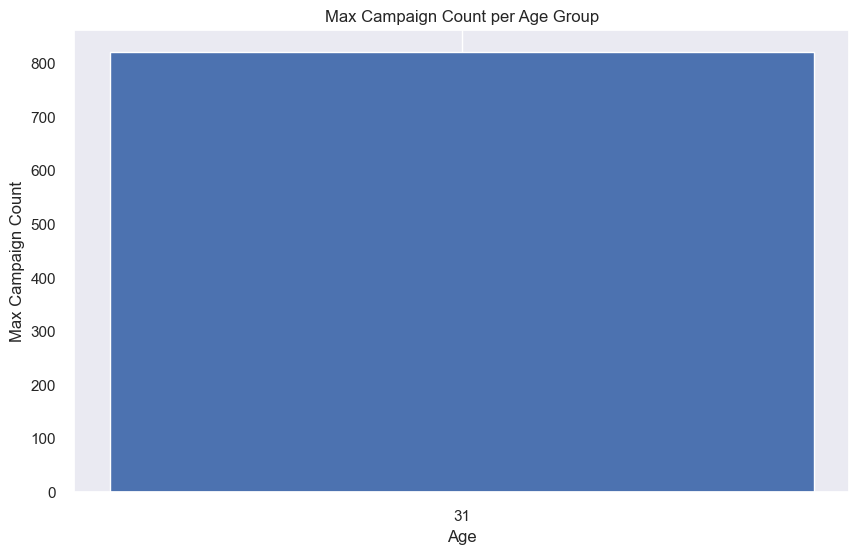

In [209]:
age_vs_campaign = df.groupby(["age", "campaign"]).size().reset_index(name='count')
age_vs_campaign_target = age_vs_campaign.groupby("age")['count'].max()
max_campaign_age = age_vs_campaign_target[age_vs_campaign_target == age_vs_campaign_target.max()]
print(max_campaign_age)


plt.figure(figsize=(10, 6))
plt.bar(max_campaign_age.index, max_campaign_age.values)
plt.xlabel('Age')
plt.ylabel('Max Campaign Count')
plt.title('Max Campaign Count per Age Group')
plt.xticks(max_campaign_age.index)  # Set x-axis ticks to display age values
plt.grid(axis='y')  # Add horizontal gridlines for better readability
plt.show()


      age  campaign   contact day_of_week  default  default_count
0      17         1  cellular         tue       no              1
1      17         2  cellular         fri       no              2
2      17         3  cellular         fri       no              1
3      17         3  cellular         wed       no              1
4      18         1  cellular         fri       no              3
...   ...       ...       ...         ...      ...            ...
6309   92         3  cellular         wed  unknown              1
6310   94         1  cellular         wed       no              1
6311   95         1  cellular         thu       no              1
6312   98         1  cellular         fri  unknown              1
6313   98         2  cellular         fri  unknown              1

[6314 rows x 6 columns]
      age  campaign   contact day_of_week default  default_count
1188   31         2  cellular         tue     yes              1
4040   48         1  cellular         tue     yes    

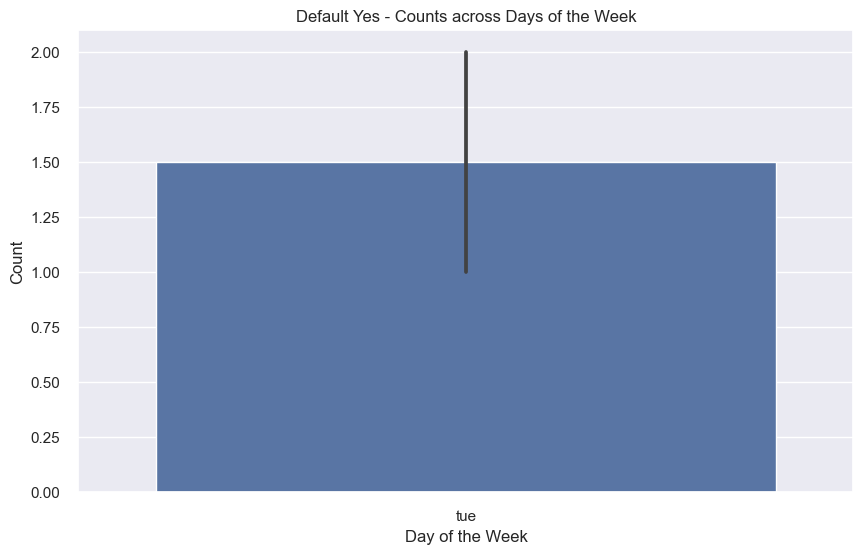

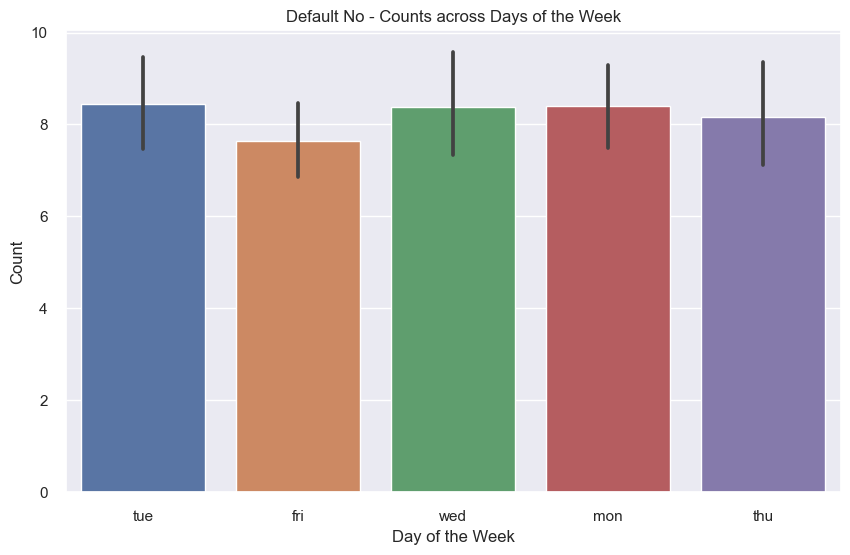

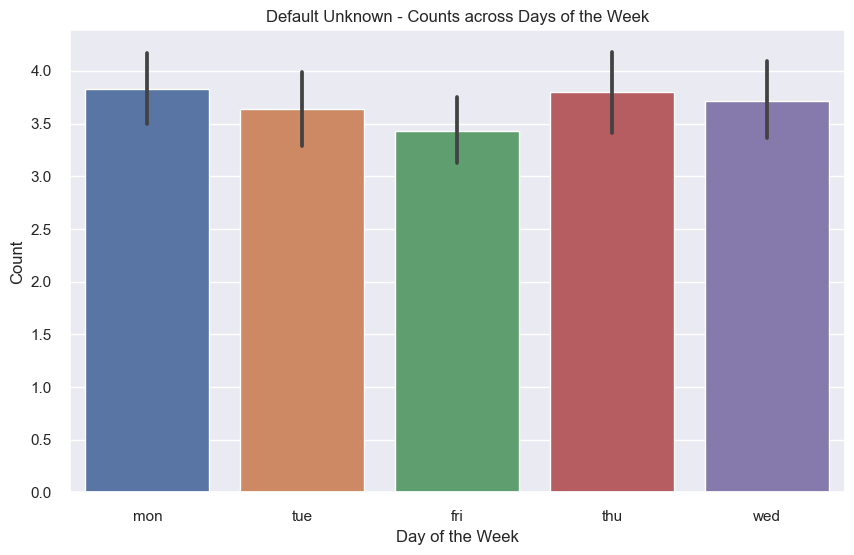

In [210]:
default_count_by_group = df.groupby(["age", "campaign", "contact", "day_of_week"])['default'].value_counts().reset_index(name='default_count')
print(default_count_by_group)

default_yes = default_count_by_group[default_count_by_group['default'] == 'yes']
default_no = default_count_by_group[default_count_by_group['default'] == 'no']
default_unknown = default_count_by_group[default_count_by_group['default'] == 'unknown']

print(default_yes) #Default yes people value counts shows that tuesday is good day to call. Old campain stragegy is bad.
# Also default
print(default_no)# Default no people cardinality is 3976 so bank must be worked on those people.
# Changing strategy, give some promotions such as discount.

print(default_unknown) # Default unknown people cardinality is 2336. Bank should learn they take campaign or not.
# Or if we assume they all do not take campaign before, bank would change campaign stragey for those people.

plt.figure(figsize=(10, 6))
sns.barplot(data=default_yes, x='day_of_week', y='default_count')
plt.title('Default Yes - Counts across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(data=default_no, x='day_of_week', y='default_count')
plt.title('Default No - Counts across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=default_unknown, x='day_of_week', y='default_count')
plt.title('Default Unknown - Counts across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()



       age  campaign  cons.conf.idx  cons.price.idx    contact day_of_week default            education  emp.var.rate  euribor3m housing          job loan   marital month  nr.employed  pdays     poutcome  previous    y  economic_index  emp_var_euribor3m_sum  emp.var.rate_euribor3m_mult  unemployment_change  total_campaign_per_contacts
18      50         1        -36.400          93.994  telephone         mon      no             basic.9y         1.100      4.857     yes  blue-collar  yes   married   may     5191.000    999  nonexistent         0   no          19.221                  5.957                        5.343             5710.100                        17642
46      57         1        -36.400          93.994  telephone         mon      no    university.degree         1.100      4.857     yes       admin.  yes   married   may     5191.000    999  nonexistent         0   no          19.221                  5.957                        5.343             5710.100                   

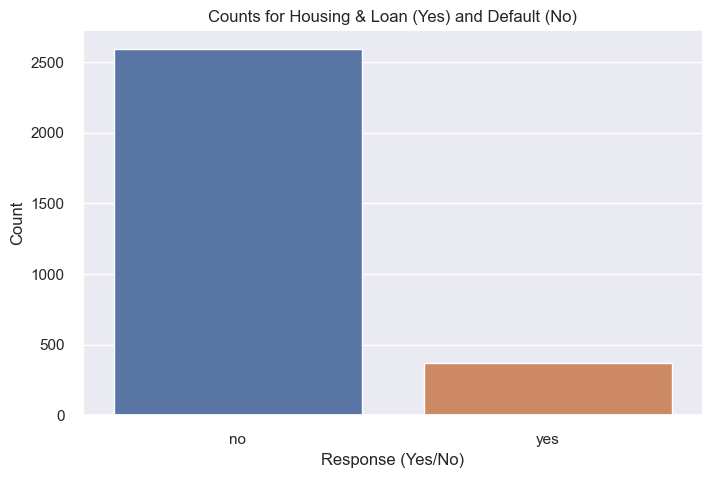

In [212]:
housing_loan_vs_default_no = df[(df['housing'] == 'yes') & (df['loan'] == 'yes') & (df['default'] == 'no')]
print(housing_loan_vs_default_no)

housing_loan_vs_default_no_y_yes = housing_loan_vs_default_no[housing_loan_vs_default_no['y'] =='yes']
print(housing_loan_vs_default_no_y_yes) # 373 people in this group

housing_loan_vs_default_no_y_no = housing_loan_vs_default_no[housing_loan_vs_default_no['y'] =='no']
print(housing_loan_vs_default_no_y_no) #2595 people in this group, so banking strategy group must work on this people.
# For example, they can try same strategy which used on housing_loan_vs_default_no_y_yes people.

housing_loan_vs_default_yes= df[(df['housing'] == 'yes') & (df['loan'] == 'yes') & (df['default'] == 'yes')]
print(housing_loan_vs_default_yes) # Empty set, these people churned, so strategy is those people must integrate the
# system by using promotion, discount.

housing_loan_vs_default_yes_y_no = housing_loan_vs_default_yes[housing_loan_vs_default_yes['y'] =='yes']
print(housing_loan_vs_default_yes_y_no)  #Banking campaing strategist must focus housing=yes, loan=yes people

plt.figure(figsize=(8, 5))
sns.countplot(data=housing_loan_vs_default_no, x='y')
plt.title('Counts for Housing & Loan (Yes) and Default (No)')
plt.xlabel('Response (Yes/No)')
plt.ylabel('Count')
plt.show()




In [213]:
# Encoding Stage
columns_to_encode = df.select_dtypes(include='object').columns

ordinal_encoders = {}

for column in columns_to_encode:

    ordinal_encoder = OrdinalEncoder()

    df[column] = ordinal_encoder.fit_transform(df[[column]])

    df_test[column] = ordinal_encoder.fit_transform(df_test[[column]])

df.drop(columns=['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome'], inplace=True)
df_test.drop(columns=['contact', 'day_of_week', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'month', 'poutcome'], inplace=True)


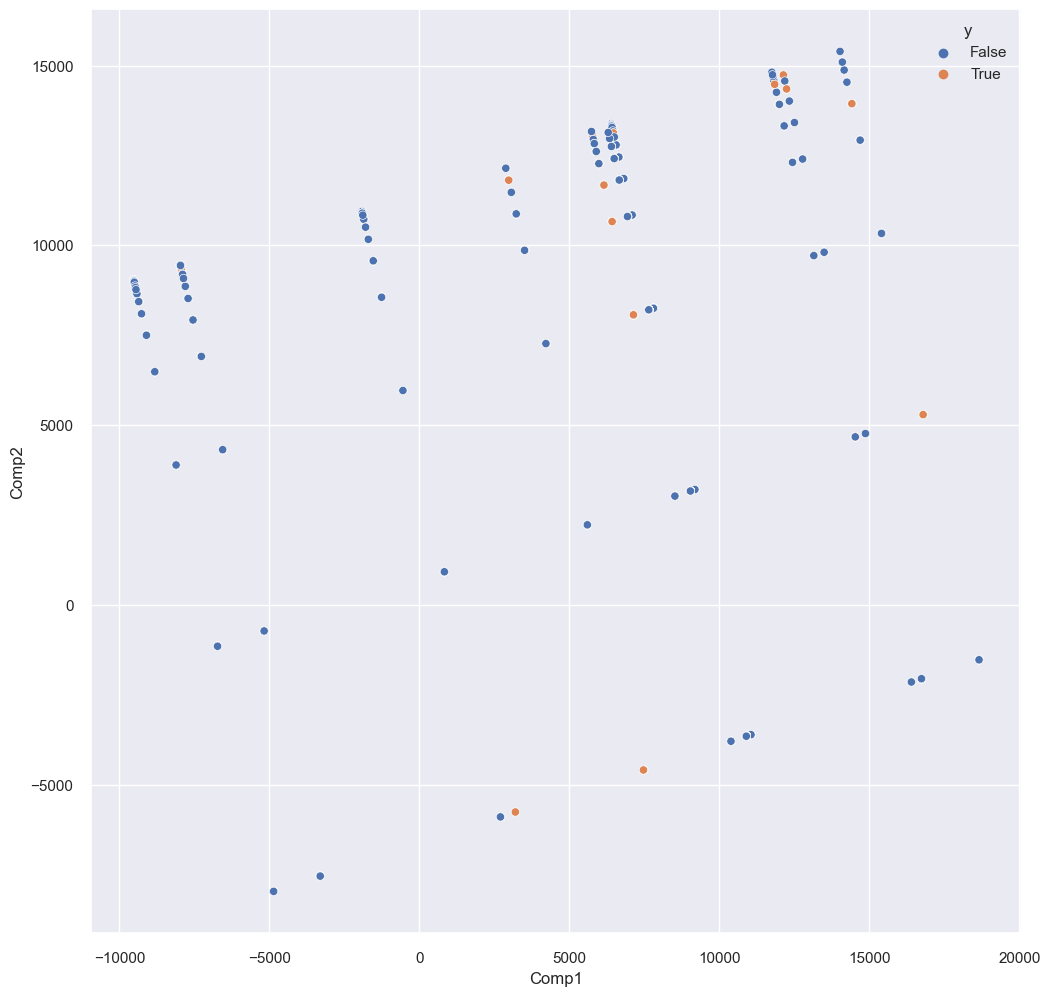

In [214]:
def grap_by_pca_numeric(dataframe):

    numeric_data = dataframe.select_dtypes(include=['float64', 'int64'])

    pca = PCA(n_components=2, random_state=50)
    X = numeric_data.drop('y', axis=1)
    y = numeric_data['y'].astype('bool')
    pca_result = pd.DataFrame(pca.fit_transform(X), columns=['Comp1', 'Comp2'])
    pca_result['y'] = y

    sns.scatterplot(data=pca_result, x='Comp1', y='Comp2', hue='y', palette='deep')
    plt.show()

grap_by_pca_numeric(df)

In [215]:
# Dataframe variable setup to create ml model.
X = df.drop('y', axis=1)

y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, shuffle=True, stratify=y)

In [216]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                    ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.681 (LR) 
accuracy: 0.4979 (KNN) 


KeyboardInterrupt: 

In [ ]:

#Creating pipeline by using skitlearn pipeline.

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=2)),  
    ('log_reg', LogisticRegression()) 
])


pipeline.fit(X_train, y_train)


In [ ]:
accuracy = pipeline.score(X_test, y_test)
print(f"Test Accuracy Score: {accuracy}")

test_preds = pipeline.predict(X_test)
test_roc_auc = roc_auc_score(y_test, test_preds)
print(f"Test Set AUC Score: {test_roc_auc}")

In [ ]:
# Hyperparametre optimization by using optuna.
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 15),  # Regularization parameter
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),  # Solver selection
        'max_iter': trial.suggest_int('max_iter', 100, 5000),  # Maximum number of iterations
    }

    model = LogisticRegression(**params, n_jobs=-1)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1
    roc_auc = roc_auc_score(y_test, preds)

    return roc_auc

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)

# Get best parameters and best value
best_params = study.best_params
best_value = study.best_value

print(f"Best Value: {best_value}")
print(f"Best Parameters: {best_params}")



In [ ]:
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Using the best parameters obtained from Optuna
model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

final_preds = model.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1
final_roc_auc = roc_auc_score(y_test, final_preds)
print(f"Test Set AUC: {final_roc_auc}")
